In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [41]:
# CLEAR Regime Params
tau_0 = 1.0
kappa = 1/0.14
chi = 2.6 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
n0 = 3.6
res_amp_scaling = 1/0.5
actual_max_photons = n0 * (1. - jnp.exp(-0.5 * kappa * tau_0)) ** 2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 0.8
gamma_I = 1/140
num_t1 = 3.0
photon_gamma = 1/500
init_fid = 1 - 1e-4
photon_weight = 4.0
shot_noise_std = 0.0
standard_fid = 0.99

time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 0.0
smoothness_baseline_scale = 1.0
apply_smoothing = True
use_processed_action = True
bandwidth = 20.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.
apply_bandwidth_constraint = True

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 3000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    # "KERNEL_SIZE": 15,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 3.6
Actual Max Photons: 3.4004130149706335


In [42]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**env_config)

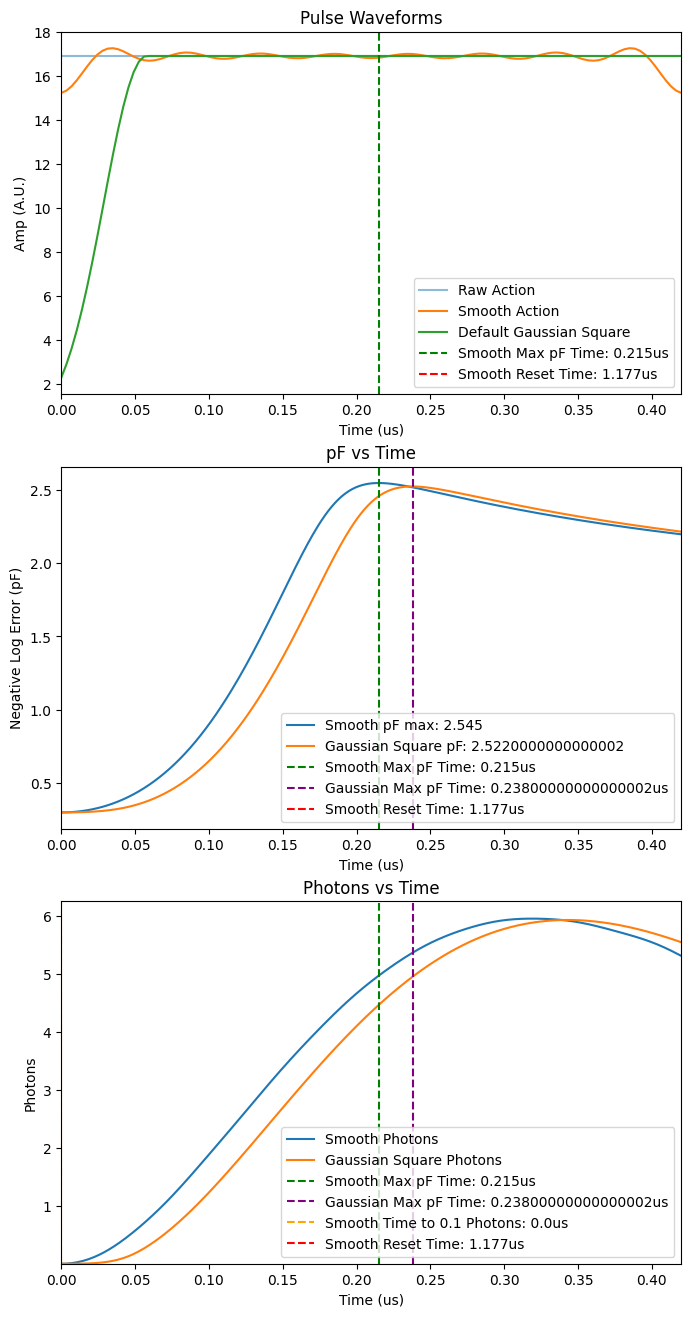

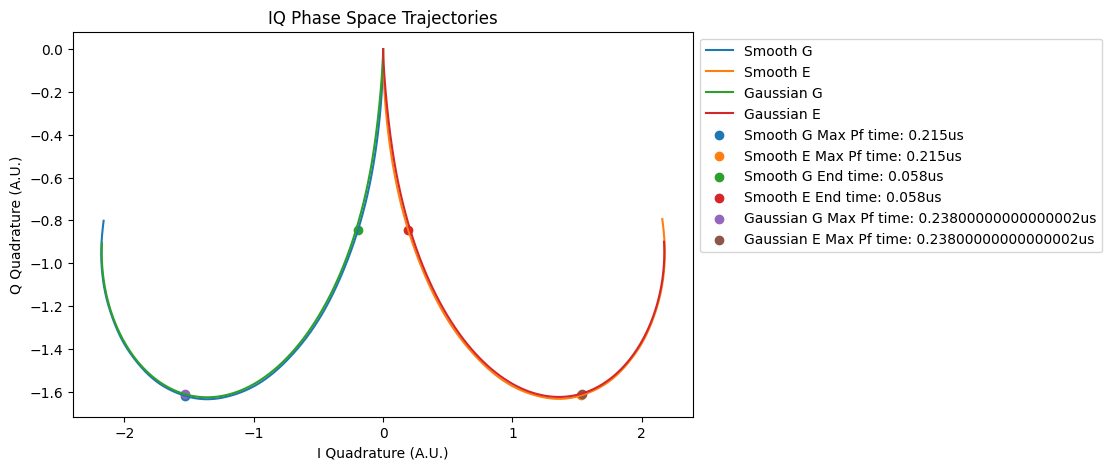

In [43]:
standard_action = jnp.ones_like(env.ts_action)

env.rollout_action(_rng, standard_action, bound_plots=True)

In [47]:
from rl_algos.ppo_continuous import PPO_make_train as PPO_make_train
from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train
from jax import jit, vmap, block_until_ready
import time

In [48]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [49]:
single_train = jit(PPO_Clipped_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: 8.22
max pF: 1.9060000000000001
max photon: 2.176
photon time: 0.5971000000000001
smoothness: 9.8e-05
bandwidth: 18.549
global update: 200
reward: 13.898
max pF: 2.335
max photon: 3.043
photon time: 0.5266000000000001
smoothness: 0.00019099999999999998
bandwidth: 18.733
global update: 300
reward: 15.199
max pF: 2.395
max photon: 3.168
photon time: 0.4636
smoothness: 0.000306
bandwidth: 18.89
global update: 400
reward: 16.394000000000002
max pF: 2.412
max photon: 3.235
photon time: 0.4359
smoothness: 0.000405
bandwidth: 18.89
global update: 500
reward: 18.197
max pF: 2.46
max photon: 3.298
photon time: 0.4101
smoothness: 0.000432
bandwidth: 18.89
global update: 600
reward: 19.287
max pF: 2.479
max photon: 3.339
photon time: 0.3866
smoothness: 0.00046699999999999997
bandwidth: 18.89
global update: 700
reward: 20.035
max pF: 2.509
max photon: 3.432
photon time: 0.3829
smoothness: 0.00047999999999999996
bandwidth: 18.89
global updat

In [50]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]

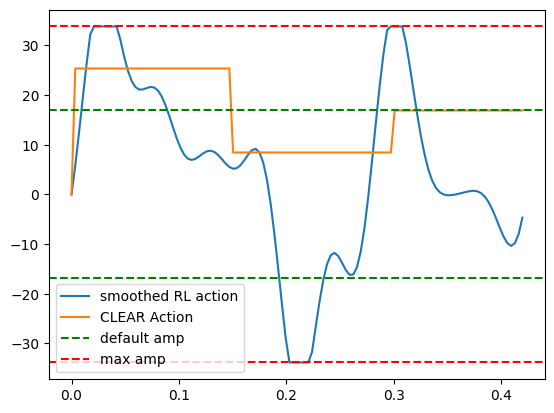

In [52]:
raw_action = actions[-1, 0]
raw_action_smooth = env.prepare_action(raw_action)

def clear_segment(ts, t0, t1, amp):
    return amp * jnp.heaviside(t1 - ts, 1.) * jnp.heaviside(ts - t0, 0.)

ts = env.ts_action

# Making CLEAR Action
delta_amp = 0.5
clear_segment_dur = 0.15
meas_duration = 0.45
clear_action = clear_segment(ts, 0., clear_segment_dur, 1. + delta_amp)
clear_action += clear_segment(ts, clear_segment_dur, 2. * clear_segment_dur, 1. - delta_amp)
clear_action += clear_segment(ts, 2. * clear_segment_dur, meas_duration, 1.)
clear_action += clear_segment(ts, meas_duration, meas_duration + clear_segment_dur, -delta_amp)
clear_action += clear_segment(ts, meas_duration + clear_segment_dur, meas_duration + 2 * clear_segment_dur, delta_amp)
clear_action *= env.a0

# plt.plot(env.ts_action, raw_action * env.a0, label='raw RL action')
plt.plot(env.ts_action, raw_action_smooth, label='smoothed RL action')
plt.plot(env.ts_action, clear_action, label='CLEAR Action')
plt.axhline(y=env.a0, label='default amp', linestyle='dashed', color='green')
plt.axhline(y=env.a0 * env.mu, label='max amp', linestyle='dashed', color='red')
plt.axhline(y=-env.a0, linestyle='dashed', color='green')
plt.axhline(y=-env.a0 * env.mu, linestyle='dashed', color='red')
plt.legend()
plt.show()

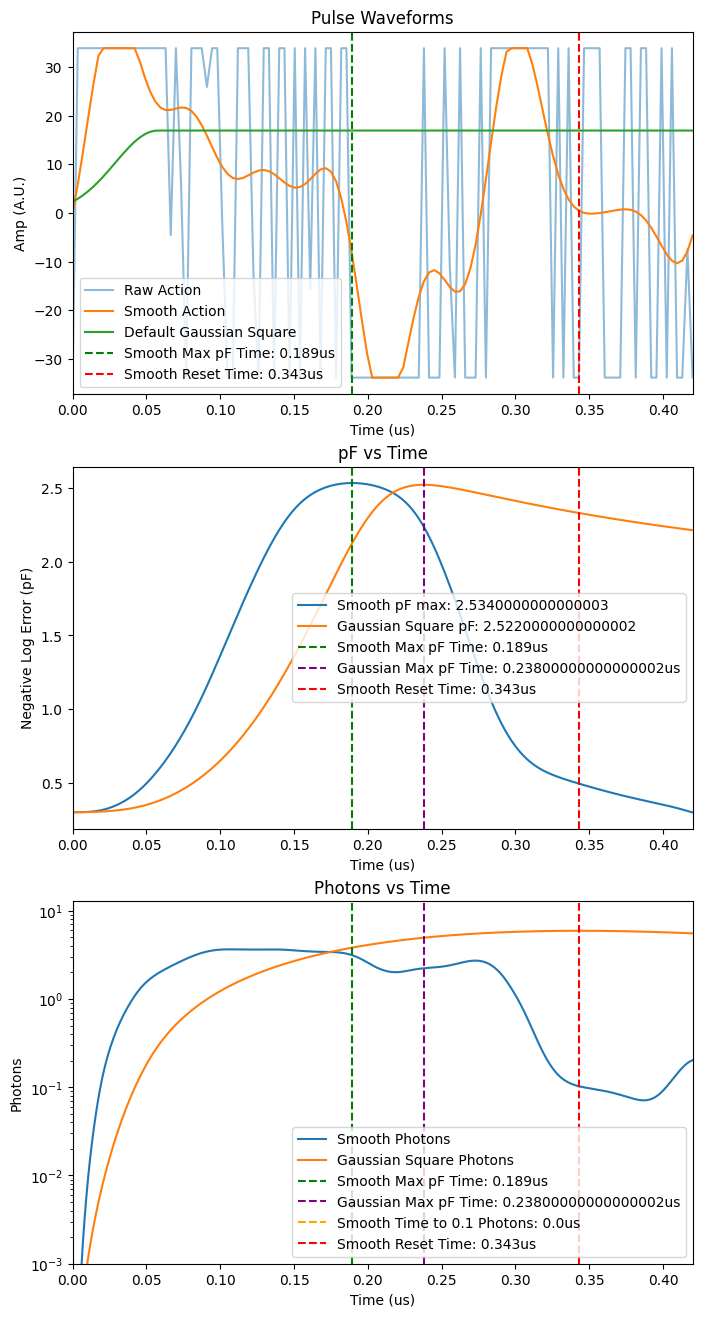

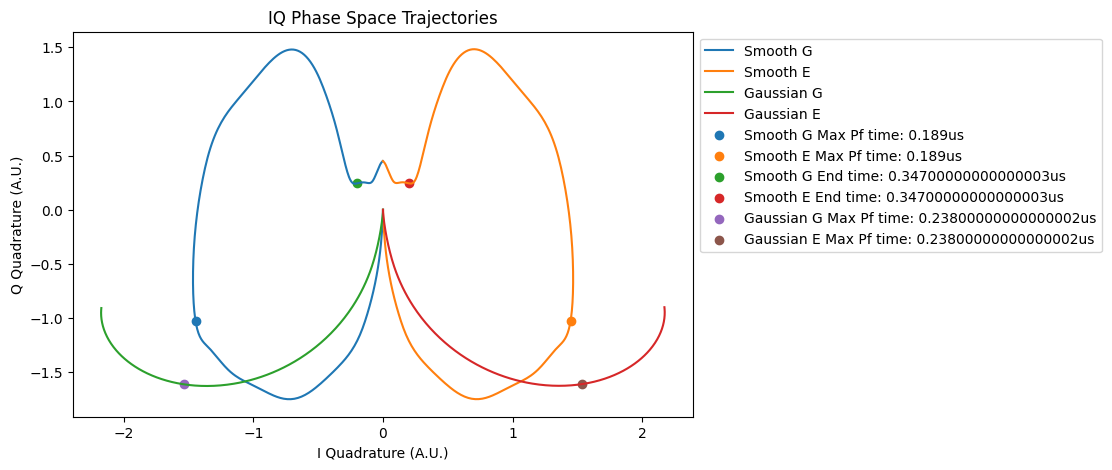

In [53]:
env.rollout_action(_rng, raw_action, photon_log_scale=True)

## Adding Bandwidth Penalty Term in Reward Function

In [54]:
config_2 = config
config_2["ENV_PARAMS"]["bandwidth_coeff"] = 25.0
config_2["ENV_PARAMS"]["use_processed_action"] = False
config_2["ENV_PARAMS"]["freq_relative_cutoff"] = 0.01

In [55]:
single_train_2 = jit(PPO_Clipped_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -912.409
max pF: 2.254
max photon: 2.854
photon time: 0.5707
smoothness: 0.548905
bandwidth: 141.65800000000002
global update: 200
reward: -912.017
max pF: 2.325
max photon: 3.012
photon time: 0.5028
smoothness: 0.626026
bandwidth: 141.667
global update: 300
reward: -911.141
max pF: 2.352
max photon: 3.037
photon time: 0.5152
smoothness: 0.6900999999999999
bandwidth: 141.677
global update: 400
reward: -910.313
max pF: 2.3850000000000002
max photon: 3.057
photon time: 0.5116
smoothness: 0.816336
bandwidth: 141.667
global update: 500
reward: -908.9920000000001
max pF: 2.415
max photon: 3.11
photon time: 0.48140000000000005
smoothness: 1.024734
bandwidth: 141.65800000000002
global update: 600
reward: -907.375
max pF: 2.461
max photon: 3.202
photon time: 0.451
smoothness: 1.117325
bandwidth: 141.65800000000002
global update: 700
reward: -906.89
max pF: 2.469
max photon: 3.216
photon time: 0.42110000000000003
smoothness: 1.274662
ban

In [56]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
bandwidths_2 = metrics_2["bandwidth"]
actions_2 = metrics_2["action"]

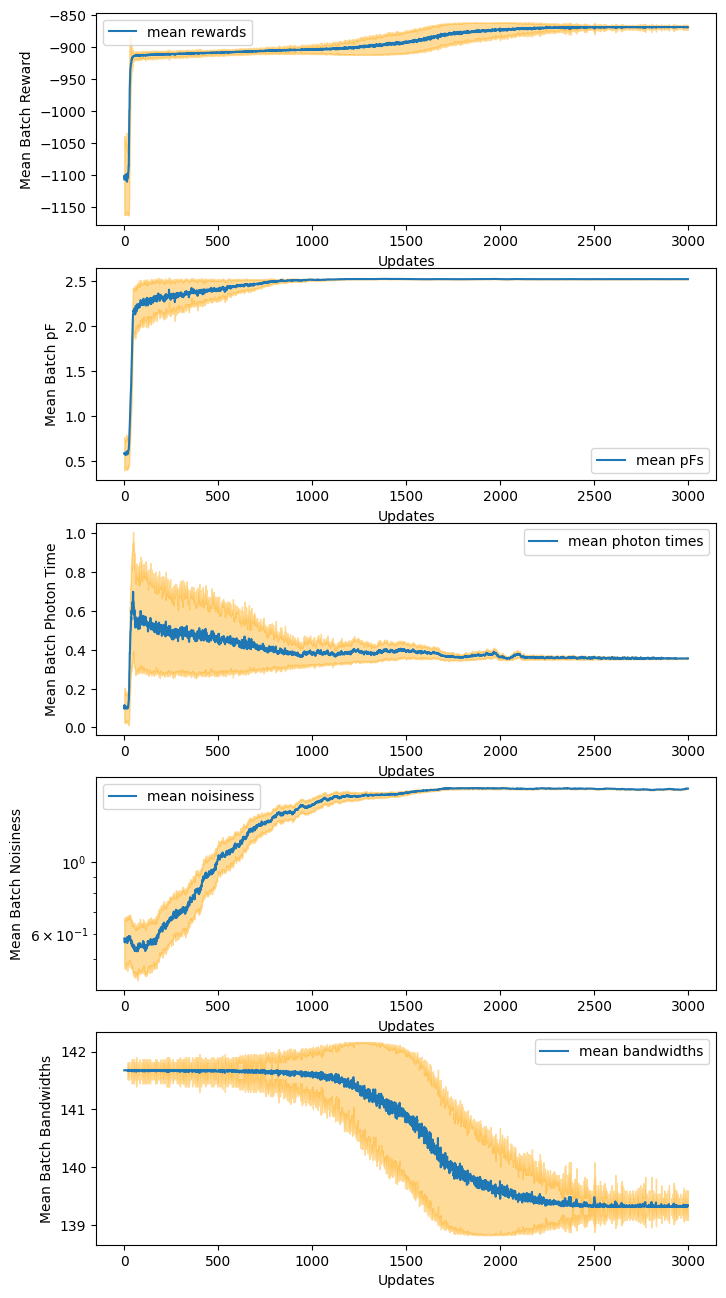

In [62]:
from utils import plot_learning

plot_learning(
    rewards=rewards_2,
    max_pFs=max_pFs_2,
    photon_times=photon_times_2,
    smoothnesses=smoothnesses_2,
    bandwidths=bandwidths_2
)

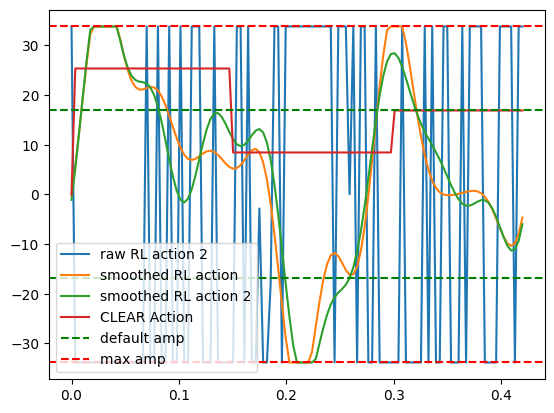

In [60]:
raw_action_2 = actions_2[-1, 0]
raw_action_smooth_2 = -env.prepare_action(raw_action_2)

def clear_segment(ts, t0, t1, amp):
    return amp * jnp.heaviside(t1 - ts, 1.) * jnp.heaviside(ts - t0, 0.)

ts = env.ts_action

# Making CLEAR Action
delta_amp = 0.5
clear_segment_dur = 0.15
meas_duration = 0.45
clear_action = clear_segment(ts, 0., clear_segment_dur, 1. + delta_amp)
clear_action += clear_segment(ts, clear_segment_dur, 2. * clear_segment_dur, 1. - delta_amp)
clear_action += clear_segment(ts, 2. * clear_segment_dur, meas_duration, 1.)
clear_action += clear_segment(ts, meas_duration, meas_duration + clear_segment_dur, -delta_amp)
clear_action += clear_segment(ts, meas_duration + clear_segment_dur, meas_duration + 2 * clear_segment_dur, delta_amp)
clear_action *= env.a0

# plt.plot(env.ts_action, raw_action_2 * env.a0, label='raw RL action 2')
plt.plot(env.ts_action, raw_action_smooth, label='smoothed RL action')
plt.plot(env.ts_action, raw_action_smooth_2, label='smoothed RL action 2')
plt.plot(env.ts_action, clear_action, label='CLEAR Action')
plt.axhline(y=env.a0, label='default amp', linestyle='dashed', color='green')
plt.axhline(y=env.a0 * env.mu, label='max amp', linestyle='dashed', color='red')
plt.axhline(y=-env.a0, linestyle='dashed', color='green')
plt.axhline(y=-env.a0 * env.mu, linestyle='dashed', color='red')
plt.legend()
plt.show()

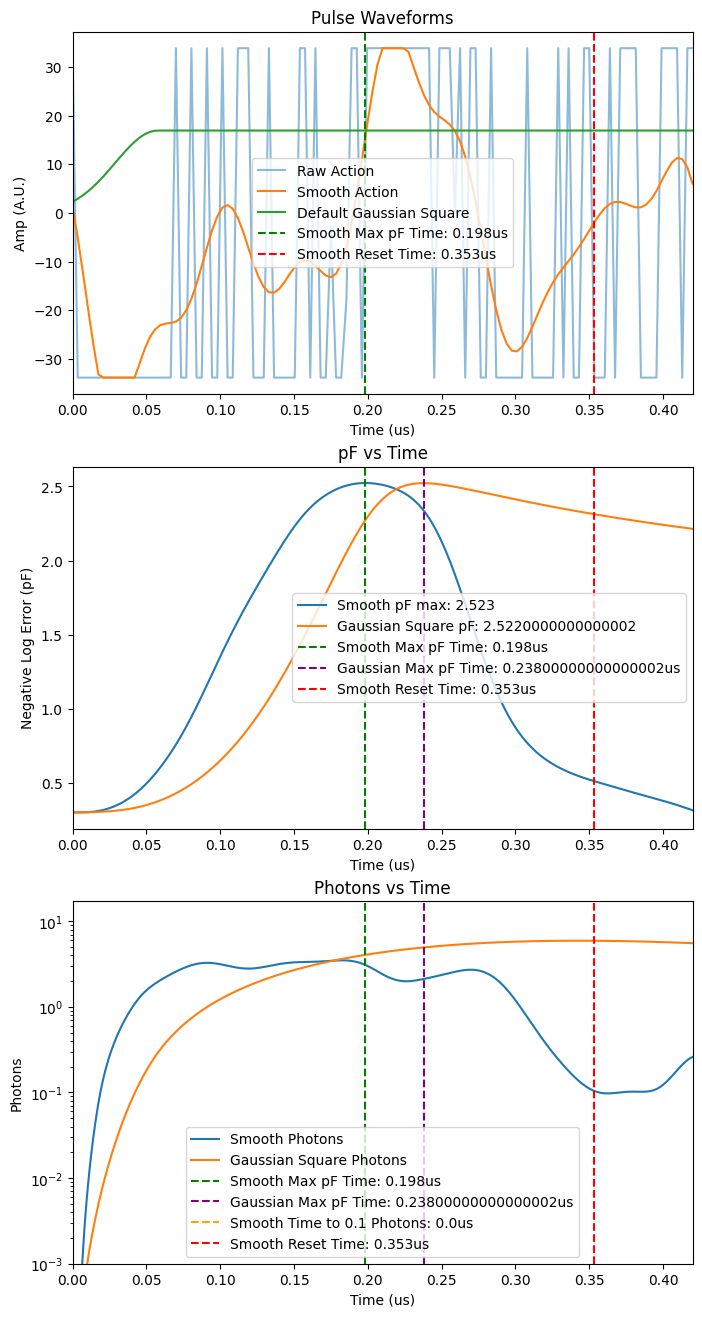

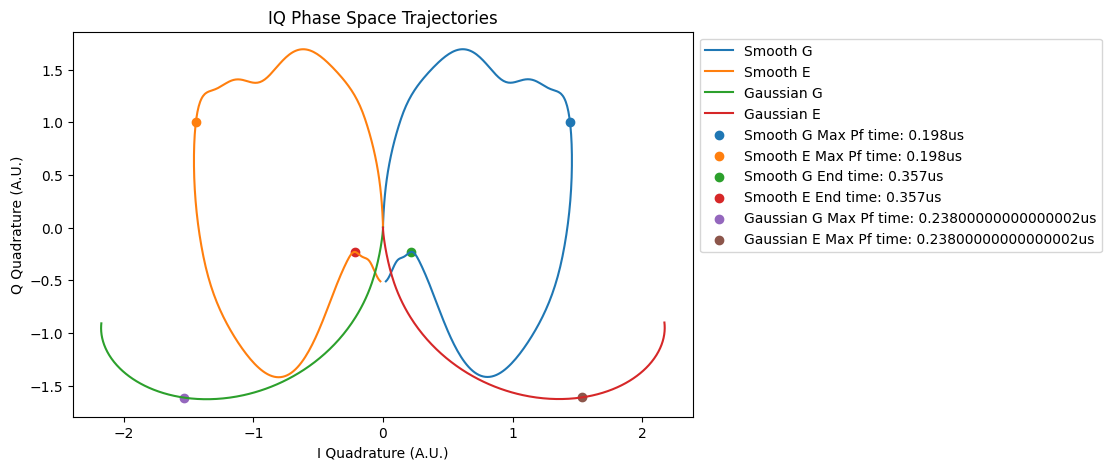

In [59]:
env.rollout_action(_rng, raw_action_2, photon_log_scale=True)

## Use PPO with Fourier Convolutional Layer for Learning Bandwidth

In [61]:
from rl_algos.ppo_fft_cnn import PPO_make_train as PPO_FTCNN_make_train

In [74]:
num_updates_fft = 5000

config_2["ENV_PARAMS"]["freq_relative_cutoff"] = 0.1
config_2["ENV_PARAMS"]["bandwidth"] = 25.
config_2["NUM_UPDATES"] = num_updates_fft

config_2

{'LR': 0.0003,
 'NUM_ENVS': 256,
 'NUM_STEPS': 1,
 'NUM_UPDATES': 5000,
 'UPDATE_EPOCHS': 4,
 'NUM_MINIBATCHES': 4,
 'CLIP_EPS': 0.2,
 'VALUE_CLIP_EPS': 0.2,
 'ENT_COEF': 0.0,
 'VF_COEF': 0.5,
 'MAX_GRAD_NORM': 0.5,
 'ACTIVATION': 'relu6',
 'LAYER_SIZE': 64,
 'ENV_NAME': 'single_langevin_env',
 'ENV_PARAMS': {'kappa': 7.142857142857142,
  'chi': 16.336281798666924,
  'kerr': 0.002,
  'time_coeff': 10.0,
  'snr_coeff': 10.0,
  'smoothness_coeff': 0.0,
  'smoothness_baseline_scale': 1.0,
  'apply_smoothing': True,
  'use_processed_action': False,
  'bandwidth': 25.0,
  'freq_relative_cutoff': 0.1,
  'bandwidth_coeff': 25.0,
  'apply_bandwidth_constraint': True,
  'n0': 3.6,
  'tau_0': 1.0,
  'res_amp_scaling': 2.0,
  'nR': 0.1,
  'snr_scale_factor': 0.8,
  'gamma_I': 0.007142857142857143,
  'photon_gamma': 0.002,
  'num_t1': 3.0,
  'init_fid': 0.9999,
  'photon_weight': 4.0,
  'standard_fid': 0.99,
  'shot_noise_std': 0.0},
 'ANNEAL_LR': False,
 'DEBUG': True,
 'DEBUG_ACTION': False,
 'P

In [75]:
single_train_3 = jit(PPO_FTCNN_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates_fft} Updates")
start = time.time()
single_result_3 = single_train_3(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -525.756
max pF: 2.265
max photon: 2.947
photon time: 0.512
smoothness: 0.56006
bandwidth: 140.92000000000002
global update: 200
reward: -521.214
max pF: 2.328
max photon: 3.278
photon time: 0.6571
smoothness: 0.596443
bandwidth: 140.358
global update: 300
reward: -512.146
max pF: 2.408
max photon: 3.5300000000000002
photon time: 0.6641
smoothness: 0.668667
bandwidth: 139.07500000000002
global update: 400
reward: -487.56
max pF: 2.442
max photon: 3.791
photon time: 0.6605000000000001
smoothness: 0.562634
bandwidth: 135.69
global update: 500
reward: -394.01300000000003
max pF: 2.48
max photon: 4.163
photon time: 0.8049000000000001
smoothness: 0.5185529999999999
bandwidth: 122.648
global update: 600
reward: -220.817
max pF: 2.515
max photon: 4.101
photon time: 0.6375000000000001
smoothness: 0.276254
bandwidth: 97.55
global update: 700
reward: -85.162
max pF: 2.5460000000000003
max photon: 4.151
photon time: 0.5821000000000001
smoo

In [68]:
# Extracting Results

metrics_3 = single_result_3["metrics"]

rewards_3 = metrics_3["reward"]
max_pFs_3 = metrics_3["max pF"]
max_photons_3 = metrics_3["max photon"]
photon_times_3 = metrics_3["photon time"]
smoothnesses_3 = metrics_3["smoothness"]
bandwidths_3 = metrics_3["bandwidth"]
actions_3 = metrics_3["action"]

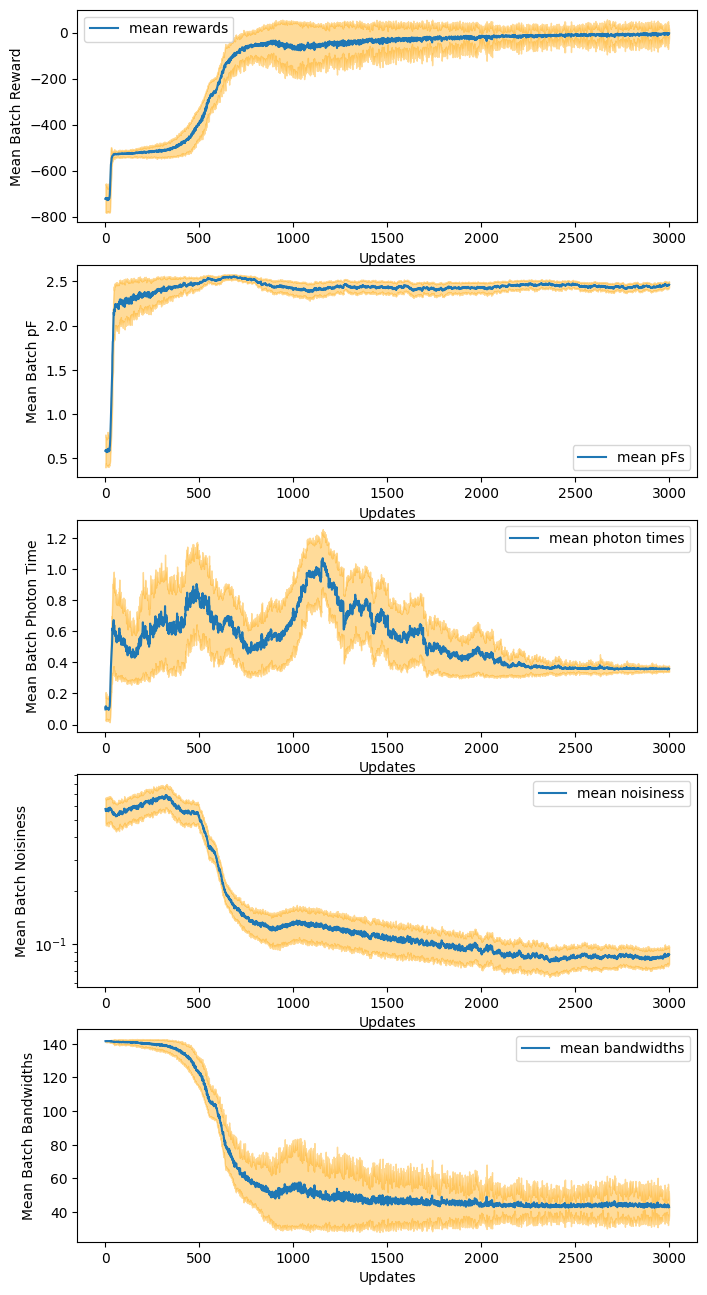

In [69]:
plot_learning(
    rewards=rewards_3,
    max_pFs=max_pFs_3,
    photon_times=photon_times_3,
    smoothnesses=smoothnesses_3,
    bandwidths=bandwidths_3
)

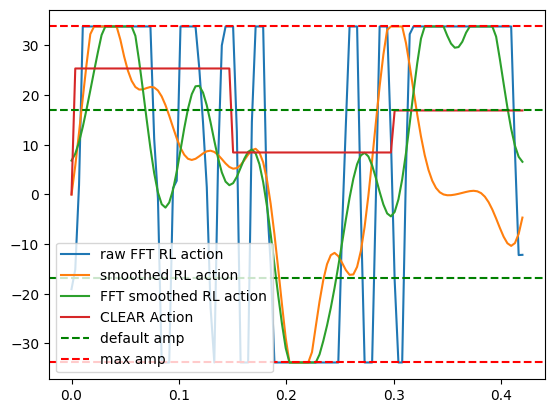

In [72]:
raw_action_3 = actions_3[-1, 0]
raw_action_smooth_3 = env.prepare_action(raw_action_3)

def clear_segment(ts, t0, t1, amp):
    return amp * jnp.heaviside(t1 - ts, 1.) * jnp.heaviside(ts - t0, 0.)

ts = env.ts_action

# Making CLEAR Action
delta_amp = 0.5
clear_segment_dur = 0.15
meas_duration = 0.45
clear_action = clear_segment(ts, 0., clear_segment_dur, 1. + delta_amp)
clear_action += clear_segment(ts, clear_segment_dur, 2. * clear_segment_dur, 1. - delta_amp)
clear_action += clear_segment(ts, 2. * clear_segment_dur, meas_duration, 1.)
clear_action += clear_segment(ts, meas_duration, meas_duration + clear_segment_dur, -delta_amp)
clear_action += clear_segment(ts, meas_duration + clear_segment_dur, meas_duration + 2 * clear_segment_dur, delta_amp)
clear_action *= env.a0

plt.plot(env.ts_action, raw_action_3 * env.a0, label='raw FFT RL action')
plt.plot(env.ts_action, raw_action_smooth, label='smoothed RL action')
plt.plot(env.ts_action, raw_action_smooth_3, label='FFT smoothed RL action')
plt.plot(env.ts_action, clear_action, label='CLEAR Action')
plt.axhline(y=env.a0, label='default amp', linestyle='dashed', color='green')
plt.axhline(y=env.a0 * env.mu, label='max amp', linestyle='dashed', color='red')
plt.axhline(y=-env.a0, linestyle='dashed', color='green')
plt.axhline(y=-env.a0 * env.mu, linestyle='dashed', color='red')
plt.legend()
plt.show()

## PPO + Clipped Distr w additional Smoothness in Reward

In [78]:
config_3 = config
config_3["ENV_PARAMS"]["smoothness_coeff"] = 0.01
config_3["ENV_PARAMS"]["use_processed_action"] = False

config_3

{'LR': 0.0003,
 'NUM_ENVS': 256,
 'NUM_STEPS': 1,
 'NUM_UPDATES': 5000,
 'UPDATE_EPOCHS': 4,
 'NUM_MINIBATCHES': 4,
 'CLIP_EPS': 0.2,
 'VALUE_CLIP_EPS': 0.2,
 'ENT_COEF': 0.0,
 'VF_COEF': 0.5,
 'MAX_GRAD_NORM': 0.5,
 'ACTIVATION': 'relu6',
 'LAYER_SIZE': 64,
 'ENV_NAME': 'single_langevin_env',
 'ENV_PARAMS': {'kappa': 7.142857142857142,
  'chi': 16.336281798666924,
  'kerr': 0.002,
  'time_coeff': 10.0,
  'snr_coeff': 10.0,
  'smoothness_coeff': 0.01,
  'smoothness_baseline_scale': 1.0,
  'apply_smoothing': True,
  'use_processed_action': False,
  'bandwidth': 25.0,
  'freq_relative_cutoff': 0.1,
  'bandwidth_coeff': 25.0,
  'apply_bandwidth_constraint': True,
  'n0': 3.6,
  'tau_0': 1.0,
  'res_amp_scaling': 2.0,
  'nR': 0.1,
  'snr_scale_factor': 0.8,
  'gamma_I': 0.007142857142857143,
  'photon_gamma': 0.002,
  'num_t1': 3.0,
  'init_fid': 0.9999,
  'photon_weight': 4.0,
  'standard_fid': 0.99,
  'shot_noise_std': 0.0},
 'ANNEAL_LR': False,
 'DEBUG': True,
 'DEBUG_ACTION': False,
 '

In [79]:
single_train_4 = jit(PPO_Clipped_make_train(config_3), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_4 = single_train_4(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -529.4300000000001
max pF: 2.282
max photon: 2.94
photon time: 0.6071000000000001
smoothness: 0.535289
bandwidth: 140.90200000000002
global update: 200
reward: -526.696
max pF: 2.319
max photon: 3.194
photon time: 0.4363
smoothness: 0.504011
bandwidth: 140.828
global update: 300
reward: -515.606
max pF: 2.374
max photon: 3.472
photon time: 0.6167
smoothness: 0.478286
bandwidth: 139.214
global update: 400
reward: -490.815
max pF: 2.455
max photon: 3.854
photon time: 0.6076
smoothness: 0.415226
bandwidth: 135.681
global update: 500
reward: -370.992
max pF: 2.515
max photon: 4.881
photon time: 1.0609
smoothness: 0.304052
bandwidth: 115.14
global update: 600
reward: -204.999
max pF: 2.5500000000000003
max photon: 5.875
photon time: 1.2822
smoothness: 0.21235099999999998
bandwidth: 81.833
global update: 700
reward: -105.494
max pF: 2.571
max photon: 4.83
photon time: 0.7055
smoothness: 0.161294
bandwidth: 64.28
global update: 800
rew

In [80]:
# Extracting Results

metrics_4 = single_result_4["metrics"]

rewards_4 = metrics_4["reward"]
max_pFs_4 = metrics_4["max pF"]
max_photons_4 = metrics_4["max photon"]
photon_times_4 = metrics_4["photon time"]
smoothnesses_4 = metrics_4["smoothness"]
bandwidths_4 = metrics_4["bandwidth"]
actions_4 = metrics_4["action"]

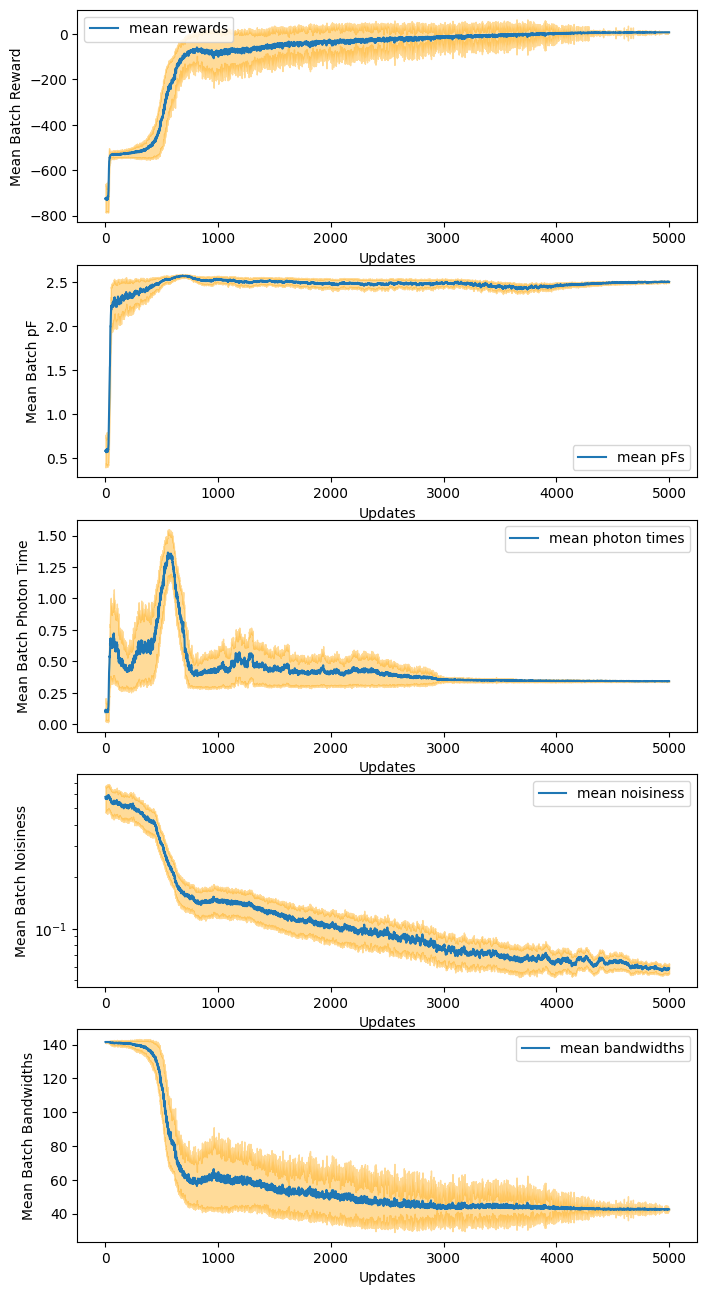

In [81]:
plot_learning(
    rewards=rewards_4,
    max_pFs=max_pFs_4,
    photon_times=photon_times_4,
    smoothnesses=smoothnesses_4,
    bandwidths=bandwidths_4
)

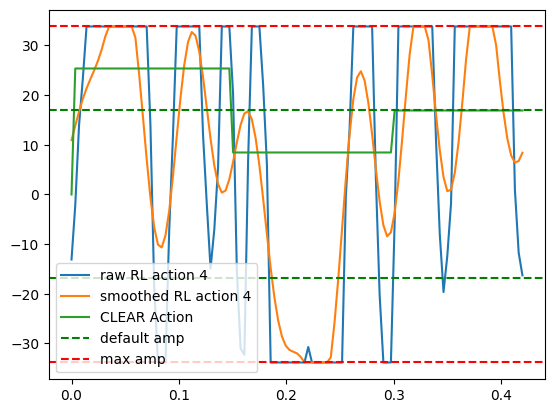

In [83]:
raw_action_4 = actions_4[-1, 0]
raw_action_smooth_4 = env.prepare_action(raw_action_4)

def clear_segment(ts, t0, t1, amp):
    return amp * jnp.heaviside(t1 - ts, 1.) * jnp.heaviside(ts - t0, 0.)

ts = env.ts_action

# Making CLEAR Action
delta_amp = 0.5
clear_segment_dur = 0.15
meas_duration = 0.45
clear_action = clear_segment(ts, 0., clear_segment_dur, 1. + delta_amp)
clear_action += clear_segment(ts, clear_segment_dur, 2. * clear_segment_dur, 1. - delta_amp)
clear_action += clear_segment(ts, 2. * clear_segment_dur, meas_duration, 1.)
clear_action += clear_segment(ts, meas_duration, meas_duration + clear_segment_dur, -delta_amp)
clear_action += clear_segment(ts, meas_duration + clear_segment_dur, meas_duration + 2 * clear_segment_dur, delta_amp)
clear_action *= env.a0

plt.plot(env.ts_action, raw_action_4 * env.a0, label='raw RL action 4')
# plt.plot(env.ts_action, raw_action_smooth, label='smoothed RL action')
plt.plot(env.ts_action, raw_action_smooth_4, label='smoothed RL action 4')
plt.plot(env.ts_action, clear_action, label='CLEAR Action')
plt.axhline(y=env.a0, label='default amp', linestyle='dashed', color='green')
plt.axhline(y=env.a0 * env.mu, label='max amp', linestyle='dashed', color='red')
plt.axhline(y=-env.a0, linestyle='dashed', color='green')
plt.axhline(y=-env.a0 * env.mu, linestyle='dashed', color='red')
plt.legend()
plt.show()

## Testing the PPO + FCNN With the Same Reward

In [84]:
single_train_f2 = jit(PPO_FTCNN_make_train(config_3), static_argnums=-1)

print(f"Starting a Run of {num_updates_fft} Updates")
start = time.time()
single_result_f2 = single_train_f2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -528.888
max pF: 2.265
max photon: 2.975
photon time: 0.5421
smoothness: 0.5409079999999999
bandwidth: 140.846
global update: 200
reward: -525.488
max pF: 2.29
max photon: 3.17
photon time: 0.5803
smoothness: 0.511016
bandwidth: 140.514
global update: 300
reward: -514.845
max pF: 2.356
max photon: 3.461
photon time: 0.6880000000000001
smoothness: 0.488421
bandwidth: 138.956
global update: 400
reward: -490.321
max pF: 2.461
max photon: 3.943
photon time: 0.6959000000000001
smoothness: 0.422066
bandwidth: 135.072
global update: 500
reward: -302.613
max pF: 2.561
max photon: 5.238
photon time: 1.2436
smoothness: 0.338679
bandwidth: 103.297
global update: 600
reward: -153.882
max pF: 2.566
max photon: 5.07
photon time: 1.1904000000000001
smoothness: 0.23113499999999998
bandwidth: 76.142
global update: 700
reward: -102.631
max pF: 2.532
max photon: 4.315
photon time: 0.6943
smoothness: 0.16402
bandwidth: 69.584
global update: 800
rew

In [85]:
# Extracting Results

metrics_f2 = single_result_f2["metrics"]

rewards_f2 = metrics_f2["reward"]
max_pFs_f2 = metrics_f2["max pF"]
max_photons_f2 = metrics_f2["max photon"]
photon_times_f2 = metrics_f2["photon time"]
smoothnesses_f2 = metrics_f2["smoothness"]
bandwidths_f2 = metrics_f2["bandwidth"]
actions_f2 = metrics_f2["action"]

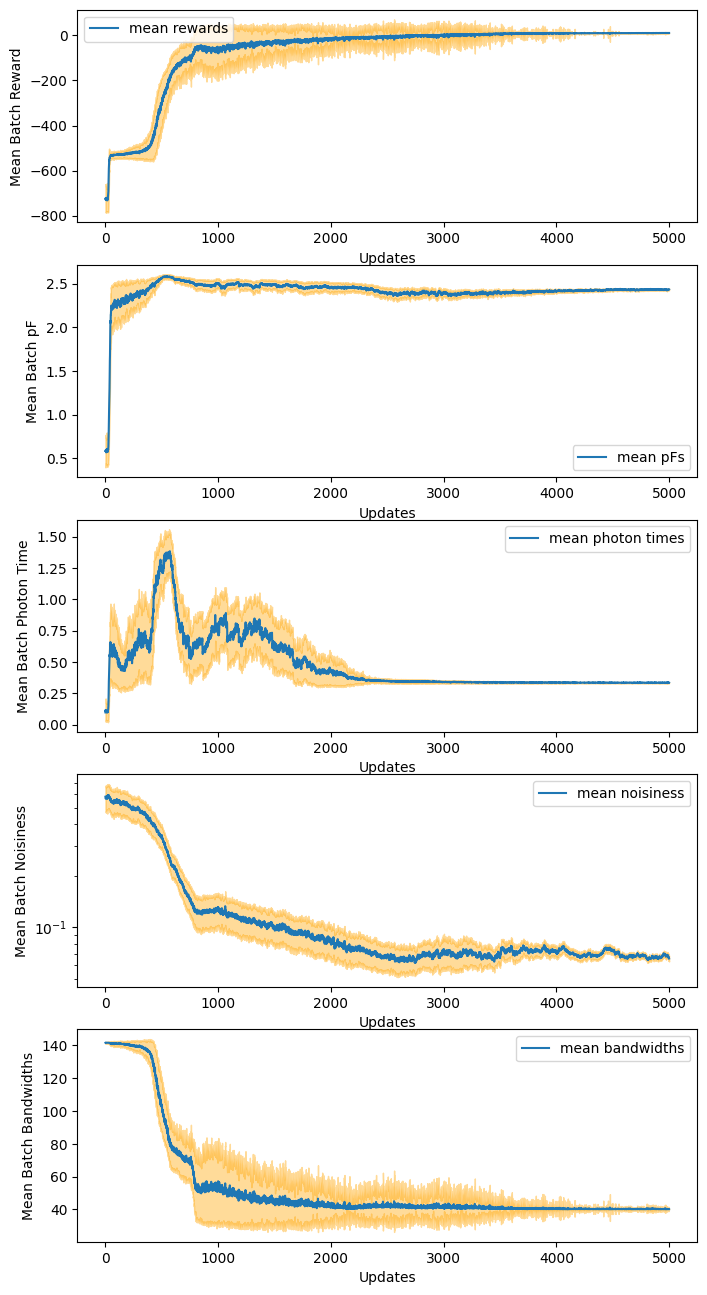

In [86]:
plot_learning(
    rewards=rewards_f2,
    max_pFs=max_pFs_f2,
    photon_times=photon_times_f2,
    smoothnesses=smoothnesses_f2,
    bandwidths=bandwidths_f2
)

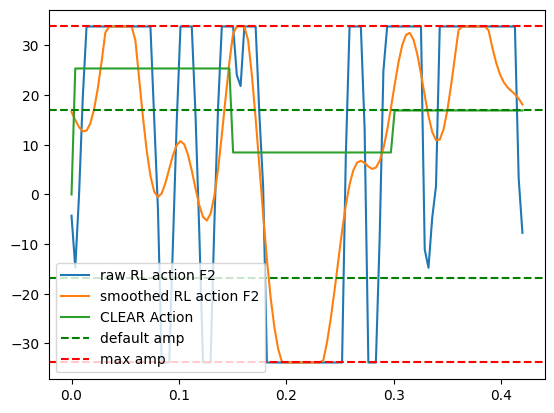

In [87]:
raw_action_f2 = actions_f2[-1, 0]
raw_action_smooth_f2 = env.prepare_action(raw_action_f2)

def clear_segment(ts, t0, t1, amp):
    return amp * jnp.heaviside(t1 - ts, 1.) * jnp.heaviside(ts - t0, 0.)

plt.plot(ts, raw_action_f2 * env.a0, label='raw RL action F2')
# plt.plot(env.ts_action, raw_action_smooth, label='smoothed RL action')
plt.plot(ts, raw_action_smooth_f2, label='smoothed RL action F2')
plt.plot(ts, clear_action, label='CLEAR Action')
plt.axhline(y=env.a0, label='default amp', linestyle='dashed', color='green')
plt.axhline(y=env.a0 * env.mu, label='max amp', linestyle='dashed', color='red')
plt.axhline(y=-env.a0, linestyle='dashed', color='green')
plt.axhline(y=-env.a0 * env.mu, linestyle='dashed', color='red')
plt.legend()
plt.show()

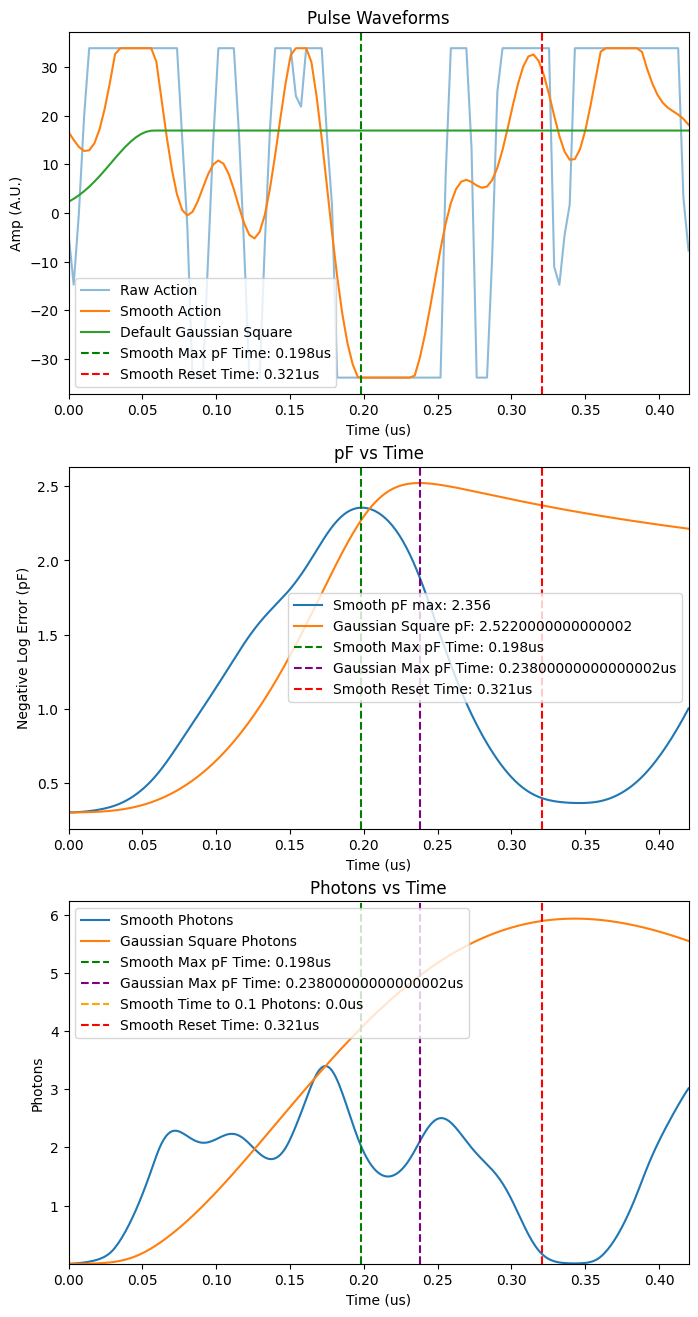

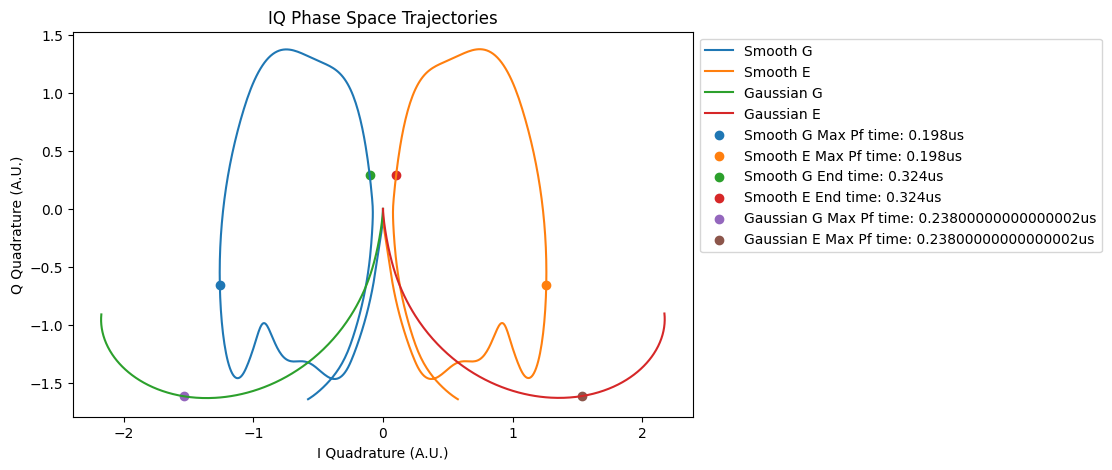

In [89]:
env.rollout_action(_rng, raw_action_f2)